### I decided to revisit the Titanic dataset, rather than the crime data (which I dislike, and seems to be mostly predicted by population).  I checked a vanilla logistic regression before adding more features and testing Ridge/Lasso.  As you'll see, I expanded a bit on previous data cleaning and visualization.
### More feature engineering could be done, especially with the Cabin, where one could extract deck information, though I'm not sure how much that would help.  I encoded everything I used to dummy variables, but discovered that it wasn't always an improvement.

### Ultimately, I played with a number of different tunings for all 3 models, and got the best results with a Ridge Classifier, though not a lot better than vanilla logistic regression.  Lasso performed poorly, and I believe that is due to not enough features, as it performs better with LOTS of them.  I suspect some correlation between features, which is probably another reason that Ridge did well.
### One thing that's obvious: data cleaning and prep work is where the bulk of time is likely spent (along with acquisition).  Actual modeling is pretty fast and multiple models won't be difficult to compare.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

In [2]:
train = pd.read_csv("/Users/aaron/thinkful/Unit 2/Titanic_train.csv")
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [4]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


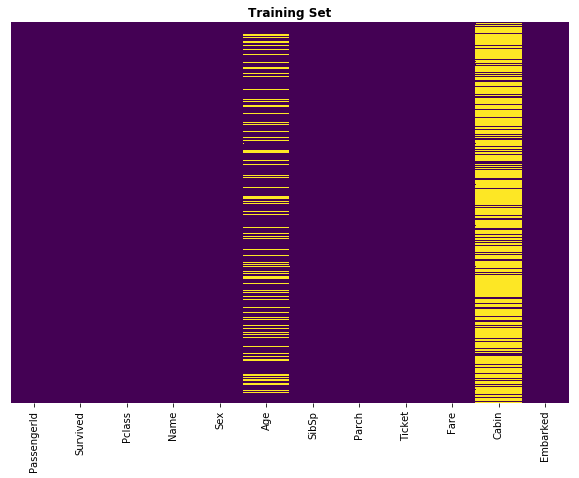

In [5]:
# A good way to look at missing data
f, axes = plt.subplots(1, 1, figsize=(10,7))
sns.heatmap(train.isnull(), yticklabels=False, cbar=False, cmap='viridis', ax=axes).set_title(
    'Training Set', fontweight='bold')
plt.show()

In [6]:
sns.set_style('whitegrid')

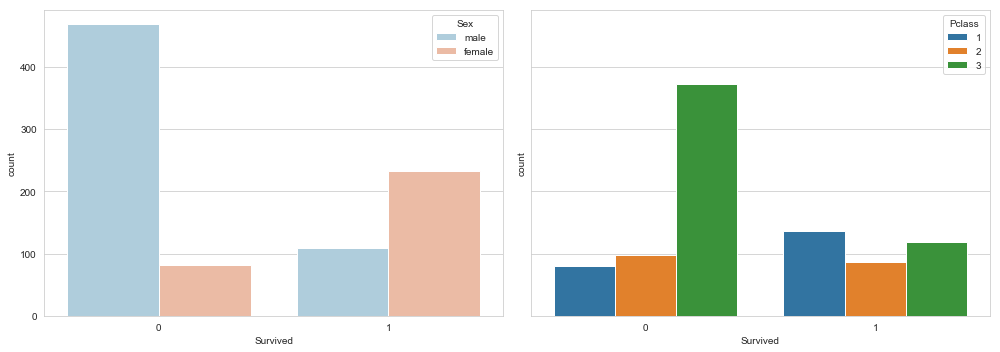

In [7]:
# Great utility of 'hue' and 'palette' shown here, see without also
f, axes = plt.subplots(1, 2, sharey=True, figsize=(14,5))
sns.countplot(x='Survived', hue='Sex', palette='RdBu_r', data=train, ax=axes[0])
sns.countplot(x='Survived', hue='Pclass', data=train, ax=axes[1])
plt.tight_layout()
plt.show()

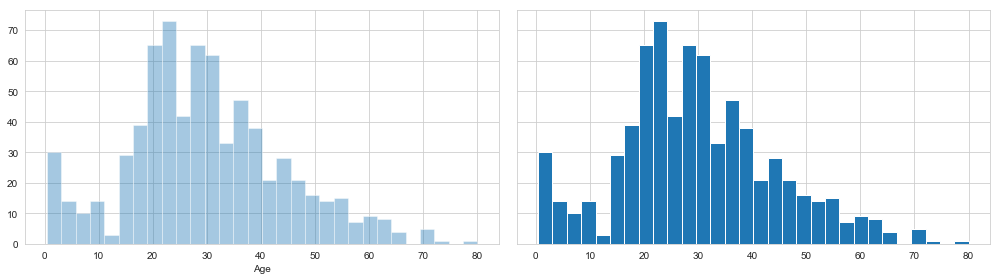

In [8]:
# side by side Seaborn and default Pandas plots, just testing
f, axes = plt.subplots(1, 2, sharey=True, figsize=(14,4))
sns.distplot(train['Age'].dropna(), kde=False, bins=30, ax=axes[0])
train['Age'].plot.hist(bins=30, ax=axes[1])
plt.tight_layout()
plt.show()

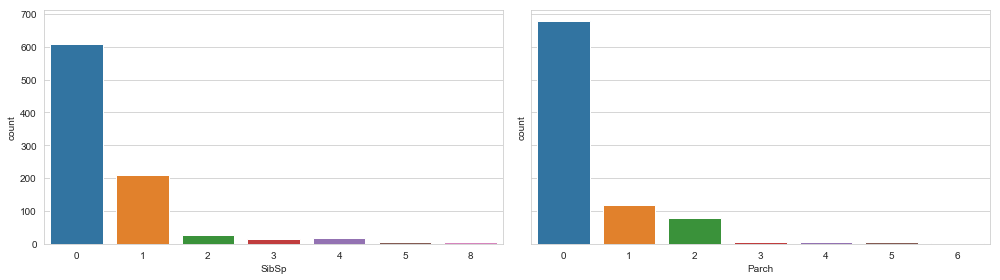

In [9]:
f, axes = plt.subplots(1, 2, sharey=True, figsize=(14,4))
sns.countplot(x='SibSp', data=train, ax=axes[0])
sns.countplot(x='Parch', data=train, ax=axes[1])
plt.tight_layout()
plt.show()

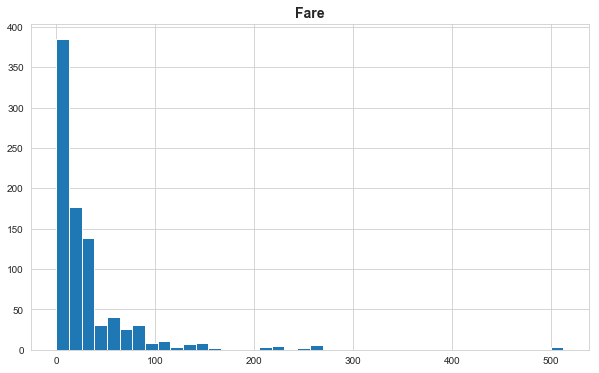

In [10]:
train['Fare'].hist(bins=40, figsize=(10,6)).set_title('Fare', fontweight='bold', fontsize=14)
plt.show()

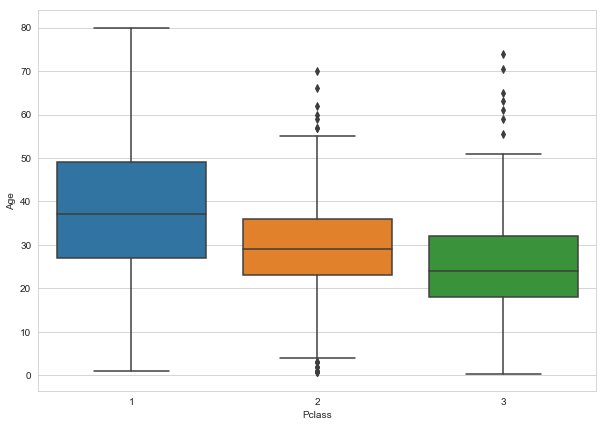

In [11]:
plt.figure(figsize=(10,7))
sns.boxplot(x='Pclass', y='Age', data=train)
plt.show()

In [12]:
# fill in missing Age data, based on average age / class
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    # only do something if it's actually missing
    if pd.isnull(Age):
        
        # I got these ages by just looking at the above graph; of course this could
        # be calculated, but this is close enough
        if Pclass == 1:
            return 37
        elif Pclass == 2:
            return 29
        else: 
            return 24
    else:
        return Age

In [13]:
train['Age'] = train[['Age', 'Pclass']].apply(impute_age, axis=1)

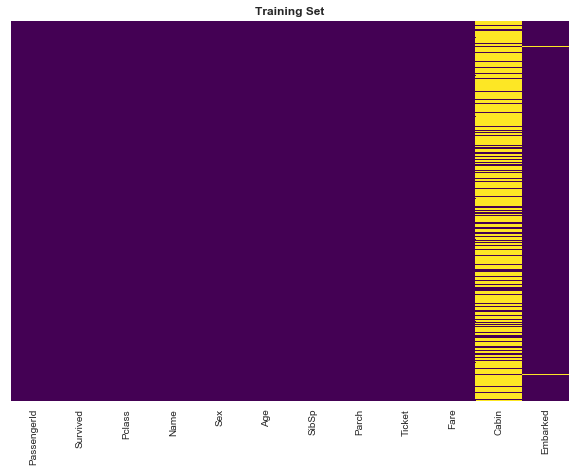

In [14]:
f, axes = plt.subplots(1, 1, figsize=(10,7))
sns.heatmap(train.isnull(), yticklabels=False, cbar=False, cmap='viridis', ax=axes).set_title(
    'Training Set', fontweight='bold')
plt.show()

In [15]:
# Dropping this because I'm not extracting features, though another iteration
# might make sense and be useful.
train.drop('Cabin', axis=1, inplace=True)
train.dropna(inplace=True)

In [16]:
sex = pd.get_dummies(train['Sex'], drop_first=True)
embark = pd.get_dummies(train['Embarked'], drop_first=True)
train = pd.concat([train, sex, embark], axis=1)
train.drop(['Sex', 'Embarked', 'Name', 'Ticket', 'PassengerId'], inplace=True, axis=1)
train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1


In [17]:
X = train.drop('Survived', axis=1)
y = train['Survived']

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso, Ridge
from sklearn.metrics import classification_report, confusion_matrix

In [19]:
# I like cross-validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [20]:
logmod = LogisticRegression()
logmod.fit(X_train, y_train)
predictions = logmod.predict(X_test)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### First run vanilla logistic regression, without engineering any more features

In [21]:
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print('\nR-squared:')
print(logmod.score(X_test, y_test))
print('\nIntercepts:')
print(logmod.coef_)

              precision    recall  f1-score   support

           0       0.80      0.91      0.85       163
           1       0.82      0.65      0.73       104

   micro avg       0.81      0.81      0.81       267
   macro avg       0.81      0.78      0.79       267
weighted avg       0.81      0.81      0.80       267

[[148  15]
 [ 36  68]]

R-squared:
0.8089887640449438

Intercepts:
[[-0.78495381 -0.02586373 -0.21650005 -0.08529258  0.00468572 -2.32107197
  -0.0152834  -0.16977769]]


In [22]:
train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1


### Engineer features on both Fare and Age.  I'll break the Fare into 3 main categories: Low - \\$10 or less, Medium - from \\$11 to \\$50, and High, over \\$51.  Age I'll break down similarly, but with more brackets. Obviously both will have a reference variable not shown.

In [23]:
train['Fare'].describe()

count    889.000000
mean      32.096681
std       49.697504
min        0.000000
25%        7.895800
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [24]:
train['med_fare'] = np.where((train['Fare']>10) & (train['Fare']<=50), 1, 0)
train['high_fare'] = np.where(train['Fare']>50, 1, 0)
train['child'] = np.where((train['Age']<=10) & (train['Age']>5), 1, 0)
train['young_adult'] = np.where((train['Age']>10) & (train['Age']<=20), 1, 0)
train['adult'] = np.where((train['Age']>20) & (train['Age']<=40), 1, 0)
train['older_adult'] = np.where((train['Age']>40) & (train['Age']<=60), 1, 0)
train['old_adult'] = np.where(train['Age']>60, 1, 0)
train.drop(['Age', 'Fare'], axis=1, inplace=True)

In [25]:
pclass = pd.get_dummies(train['Pclass'], drop_first=True)
train = pd.concat([train, pclass], axis=1)
train.drop(['Pclass'], axis=1, inplace=True)

In [26]:
train.head()

,Survived,SibSp,Parch,male,Q,S,med_fare,high_fare,child,young_adult,adult,older_adult,old_adult,2,3
0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,1
1,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0
2,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1
3,1,1,0,0,0,1,0,1,0,0,1,0,0,0,0
4,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1


In [27]:
X = train.drop('Survived', axis=1)
y = train['Survived']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

### I messed with a variety of parameters here, and ultimately setting the C value quite high (low regularization) gave me the best results. L2 (default) penalty better than L1, warm start, intercepts, all that is better at the default.  I'll now check how Lasso and Ridge do.
### Turns out that my feature engineering had no effect at all, but I'll leave it for now.

In [29]:
logmod = LogisticRegression(C=1e9)
logmod.fit(X_train, y_train)
predictions = logmod.predict(X_test)
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print('\nR-squared:')
print(logmod.score(X_test, y_test))
print('\nIntercepts:')
print(logmod.coef_)

              precision    recall  f1-score   support

           0       0.83      0.89      0.86       163
           1       0.80      0.71      0.76       104

   micro avg       0.82      0.82      0.82       267
   macro avg       0.82      0.80      0.81       267
weighted avg       0.82      0.82      0.82       267

[[145  18]
 [ 30  74]]

R-squared:
0.8202247191011236

Intercepts:
[[-0.49398612 -0.26445755 -2.66427681 -0.04596293 -0.36086926  0.58934434
   1.65046097 -2.22981715 -2.81871559 -2.96823284 -3.43673445 -4.95506662
  -0.57981157 -1.21969682]]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### Ok, my Ridge classifier had a gain of 1 on the vanilla.  I messed with a variety of settings, arriving here.  You can only see the gain by looking at the confusion matrix.

In [30]:
ridgeregr = RidgeClassifier(alpha=0.01, fit_intercept=True) 
ridgeregr.fit(X_train, y_train)
predictions = ridgeregr.predict(X_test)
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print('\nR-squared:')
print(ridgeregr.score(X_test, y_test))
print('\nIntercepts:')
print(ridgeregr.coef_)

              precision    recall  f1-score   support

           0       0.83      0.90      0.86       163
           1       0.82      0.70      0.76       104

   micro avg       0.82      0.82      0.82       267
   macro avg       0.82      0.80      0.81       267
weighted avg       0.82      0.82      0.82       267

[[147  16]
 [ 31  73]]

R-squared:
0.8239700374531835

Intercepts:
[[-0.11216211 -0.08077124 -0.95429552  0.00336554 -0.10979807  0.15695082
   0.49285372 -0.61332833 -0.76291991 -0.81883957 -0.9477258  -1.28413064
  -0.1594076  -0.37796469]]


### Had trouble with the Sklearn metrics here, but got the info necessary to see how poorly Lasso worked

In [31]:
lass = Lasso(alpha=.0001)
lassfit = lass.fit(X_train, y_train)
predictions = lassfit.predict(X_test)
#print(classification_report(y_test, predictions))
#print(confusion_matrix(y_test, predictions))
print('\nR-squared:')
print(lass.score(X_test, y_test))
print('\nIntercepts:')
print(lass.coef_)


R-squared:
0.42025668818776296

Intercepts:
[-0.05550873 -0.03953147 -0.47714911  0.         -0.0554518   0.07708692
  0.24490383 -0.29106707 -0.36834829 -0.39655455 -0.46000282 -0.62490537
 -0.07722822 -0.1880585 ]
